### CS512 - Segmentation and classification of skin lesions
### Contains:
#### 1. CNN
#### 2. InceptionV3 + RMSprop
#### 3. InceptionV3 + SGD


#### --------------------------------------
#### --------------------------------------
### Authors:
#### Sourav Yadav - A20450418
#### Akshay R - A20442409

In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# keras libraries
import keras

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import ReLU
from keras.layers import Add
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras import Input

# sklearn libraries
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# to make the results are reproducible
import torch
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

Using TensorFlow backend.
/Users/akshayrajeev/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/akshayrajeev/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/akshayrajeev/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/akshayrajeev/opt

#### Functions to plot Confusion Matrix

In [2]:
def plot_confusion_matrix(cm, title, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
         rotation_mode="anchor")
    fig.colorbar(im, ax=ax)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = ax.text(j, i, cm[i, j],
                 ha="center",
                 va="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylim(len(classes)-0.5, -0.5)
    ax.set_title(title)
    fig.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.show()
    
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    all_labels = np.unique(df_train.dx).tolist()
    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        __, c_ax = plt.subplots()
        c_ax.plot(fpr, tpr, 'r',label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.legend()
        c_ax.plot(fpr, fpr, '-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
    
def computeCM(model, x_features, x_labels, title, x_df):
    
    # Predict the values from the features dataset
    Y_pred = model.predict(x_features)
    
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    
    # Convert actual labels to one hot vectors
    Y_true = np.argmax(x_labels,axis = 1) 
    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, title, classes = range(7))
    
    # Print the classification report
    print('\nClassification Report\n')
    target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    print(classification_report(x_df['cell_type_idx'], Y_pred_classes, target_names=target_names))
    
    # Print the roc curves and return the multiclass ROC score
    return (multiclass_roc_auc_score(x_df['cell_type_idx'], Y_pred_classes))

def computeCMNormalized(model, x_features, x_labels, title, x_df):
    
    # Predict the values from the features dataset
    Y_pred = model.predict(x_features)
    
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    
    # Convert actual labels to one hot vectors
    Y_true = np.argmax(x_labels,axis = 1) 
    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    confusion_mtx_norm = np.round(confusion_mtx/confusion_mtx.astype(np.float).sum(axis=0), 2)

    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx_norm, title, classes = range(7))

#### Function to calculate test Performance

In [3]:
def calcTestPerformance(model):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    loss_v, accuracy_v = model.evaluate(x_val, y_val, verbose=1)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

#### Function to plot Loss and Accuracy values vs Epochs

In [4]:
def plotTrend(history, type_):
    if(type_ == 'Loss'):
        plt.plot(history.history['loss'], color = 'b', label = "Training Loss")
        plt.plot(history.history['val_loss'], color = 'r', label = "Validation Loss")
        plt.title('Loss vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        legend = plt.legend(loc='best', shadow = True)
        plt.show()
    else:
        plt.plot(history.history['accuracy'], color = 'b', label = "Training Accuracy")
        plt.plot(history.history['val_accuracy'], color = 'r', label = "Validation Accuracy")
        plt.title('Accuracy vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        legend = plt.legend(loc='best', shadow = True)
        plt.show()     

### Step 1. Data analysis and preprocessing

In [6]:
data_dir = '/Users/akshayrajeev/Documents/Deep Learning/Project/Data/skin-cancer-mnist-ham10000 (1) copy'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
len(imageid_path_dict)

10015

#### This function is used to compute the mean and standard deviation on the whole dataset, will use for inputs normalization

In [7]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 75, 100
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [8]:
norm_mean,norm_std = compute_img_mean_std(all_image_path)

100%|██████████| 10015/10015 [01:10<00:00, 143.02it/s]


(100, 75, 3, 10015)
normMean = [0.7635165, 0.5461223, 0.5705286]
normStd = [0.14083128, 0.15251277, 0.16985273]


#### Add three columns to the original DataFrame, path (image path), cell_type (the whole name),cell_type_idx (the corresponding index of cell type, as the image label )

In [9]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/akshayrajeev/Documents/Deep Learning/Pr...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/akshayrajeev/Documents/Deep Learning/Pr...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/akshayrajeev/Documents/Deep Learning/Pr...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/akshayrajeev/Documents/Deep Learning/Pr...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/akshayrajeev/Documents/Deep Learning/Pr...,Benign keratosis-like lesions,2


In [10]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [11]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/akshayrajeev/Documents/Deep Learning/Pr...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/akshayrajeev/Documents/Deep Learning/Pr...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/akshayrajeev/Documents/Deep Learning/Pr...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/akshayrajeev/Documents/Deep Learning/Pr...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/akshayrajeev/Documents/Deep Learning/Pr...,Benign keratosis-like lesions,2,duplicated


In [12]:
print(df_original['duplicates'].value_counts())

# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64


(5514, 11)

In [13]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
Y = df_undup['cell_type_idx']
_, df_TEST = train_test_split(df_undup, test_size=0.5, random_state=20449302, stratify=Y)

y = df_TEST['cell_type_idx']
df_val, df_test = train_test_split(df_TEST, test_size=0.5, random_state=20449302, stratify=y)

print(df_val.shape, df_test.shape)

(1378, 11) (1379, 11)


In [14]:
df_val['cell_type_idx'].value_counts()

4    1103
2     110
5      57
1      44
0      38
6      16
3      10
Name: cell_type_idx, dtype: int64

In [15]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.

def get_val_rows(x):
    
    # create a list of all the lesion_id's in the val set
    val_list  = list(df_val['image_id'])
    
    # create a list of all the lesion_id's in the test set
    test_list = list(df_test['image_id'])
    
    if str(x) in val_list:
        return 'val'
    elif str(x) in test_list:
        return 'test'
    else:
        return 'train'

# identify train, val and test rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val_or_test'] = df_original['image_id']

# apply the function to this new column
df_original['train_or_val_or_test'] = df_original['train_or_val_or_test'].apply(get_val_rows)

# filter out train rows
df_train = df_original[df_original['train_or_val_or_test'] == 'train']
print(len(df_train))
print(len(df_val))
print(len(df_test))

7258
1378
1379


In [16]:
df_train['cell_type_idx'].value_counts()

4    4498
5     998
2     879
1     427
0     251
6     110
3      95
Name: cell_type_idx, dtype: int64

In [17]:
0.5/df_train['cell_type_idx'].value_counts(normalize = True)

4     0.806803
5     3.636273
2     4.128555
1     8.498829
0    14.458167
6    32.990909
3    38.200000
Name: cell_type_idx, dtype: float64

In [18]:
df_train['cell_type'].value_counts()

Melanocytic nevi                  4498
Melanoma                           998
Benign keratosis-like lesions      879
Basal cell carcinoma               427
Actinic keratoses                  251
Vascular lesions                   110
Dermatofibroma                      95
Name: cell_type, dtype: int64

#### From the above statistics of each category, we can see that there is a serious class imbalance in the training data. To solve this problem, I think we can start from two aspects, one is equalization sampling, and the other is a loss function that can be used to mitigate category imbalance during training, such as focal loss.

In [19]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5] # Inverse of the value proportion, expect for the type - Melanocytic nevi  
for i in range(7): 
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

Melanoma                          39920
Dermatofibroma                     4750
Melanocytic nevi                   4498
Benign keratosis-like lesions      4395
Basal cell carcinoma               4270
Actinic keratoses                  3765
Vascular lesions                    550
Name: cell_type, dtype: int64

In [20]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [21]:
df_train['image'] = df_train['path'].map(lambda x:np.asarray(Image.open(x).resize((100,75))))
df_val['image'] = df_val['path'].map(lambda x:np.asarray(Image.open(x).resize((100,75))))
df_test['image'] = df_test['path'].map(lambda x:np.asarray(Image.open(x).resize((100,75))))

In [22]:
df_train['image'].map(lambda x : x.shape).value_counts()

(75, 100, 3)    62148
Name: image, dtype: int64

In [23]:
x_train = np.asarray(df_train['image'].tolist())
x_val   = np.asarray(df_val['image'].tolist())
x_test  = np.asarray(df_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std  = np.std(x_train)

x_train = (x_train - x_train_mean) / x_train_std
x_val   = (x_val - x_train_mean) / x_train_std
x_test  = (x_test - x_train_mean) / x_train_std 

# Label Encoding
y_train = to_categorical(df_train['cell_type_idx'], num_classes = 7)
y_val   = to_categorical(df_val['cell_type_idx'], num_classes = 7)
y_test  = to_categorical(df_test['cell_type_idx'], num_classes = 7)



In [ ]:
x_train.shape

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test  = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_val   = x_val.reshape(x_val.shape[0], *(75, 100, 3))

In [24]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    rotation_range     = 40,
    width_shift_range  = 0.2,
    height_shift_range = 0.2,
    shear_range        = 0.2,
    zoom_range         = 0.2,
    horizontal_flip    = True,
    fill_mode          = 'nearest'
)

# val_datagen  = ImageDataGenerator(rescale = 1./255)
# test_datagen = ImageDataGenerator(rescale = 1./255)

In [25]:
batch_size = 256

## training the model with the fully connected layer in conv_base is frozen
train_generator = train_datagen.flow(x_train, y_train, batch_size  = batch_size)
# val_generator = val_datagen.flow(x_val, y_val, batch_size  = batch_size)
# test_generator = test_datagen.flow(x_test, y_test, batch_size = batch_size)

In [36]:
x_val.shape

(1378, 75, 100, 3)

## CNN 

In [34]:
input_layer = Input(shape = (75, 100, 3))

#model0: block1
block1_Conv1 =  layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(input_layer)
block1_Conv2 =  layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(block1_Conv1)
block1_MPool2 = layers.MaxPooling2D(2)(block1_Conv2)
block1_Bn1 =    BatchNormalization()(block1_MPool2)
block1_dp1 =    Dropout(0.5)(block1_Bn1)

block1_Conv3 =  layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(block1_dp1)
block1_Conv4 =  layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(block1_Conv3)
block1_MPool4 = layers.MaxPooling2D(2)(block1_Conv4)
block1_Bn2 =    BatchNormalization()(block1_MPool4)
block1_dp2 =    Dropout(0.5)(block1_Bn2)

#dense block
dense1_flt =    layers.Flatten()(block1_dp2)
dense1_dense1 = layers.Dense(128, activation = 'relu')(dense1_flt)
dense1_bn1 = BatchNormalization()(dense1_dense1)
dense1_dp3 =    Dropout(0.5)(dense1_bn1)
output_layer = layers.Dense(7,activation = 'softmax')(dense1_dp3)

model0 = Model(inputs = input_layer, outputs = output_layer)
model0.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 75, 100, 3)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 37, 50, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 37, 50, 32)        128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 37, 50, 64)        1849

In [56]:
#Compile the model
epochs = 20
model0.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.0005, rho=0.9) , loss = "categorical_crossentropy", metrics=["accuracy"])


history0 = model0.fit_generator(train_generator
                                    , steps_per_epoch = x_train.shape[0]//batch_size 
                                    , epochs = epochs
                                    , validation_data = (x_val, y_val)
                                    , verbose = 1
                                    , validation_steps = x_val.shape[0]//batch_size
                                   )

Epoch 1/20


/Users/akshayrajeev/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/akshayrajeev/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


242/242 [==============================] - 320s 1s/step - loss: 1.6132 - accuracy: 0.4507 - val_loss: 4.1060 - val_accuracy: 0.0972
Epoch 2/20
242/242 [==============================] - 344s 1s/step - loss: 1.2046 - accuracy: 0.5555 - val_loss: 1.3871 - val_accuracy: 0.4673
Epoch 3/20
242/242 [==============================] - 335s 1s/step - loss: 1.0416 - accuracy: 0.6068 - val_loss: 1.0713 - val_accuracy: 0.6081
Epoch 4/20
242/242 [==============================] - 353s 1s/step - loss: 0.9602 - accuracy: 0.6394 - val_loss: 0.7754 - val_accuracy: 0.7286
Epoch 5/20
242/242 [==============================] - 369s 2s/step - loss: 0.8922 - accuracy: 0.6640 - val_loss: 0.9247 - val_accuracy: 0.6952
Epoch 6/20
242/242 [==============================] - 345s 1s/step - loss: 0.8408 - accuracy: 0.6848 - val_loss: 0.8253 - val_accuracy: 0.7417
Epoch 7/20
242/242 [==============================] - 344s 1s/step - loss: 0.8040 - accuracy: 0.6964 - val_loss: 0.6299 - val_accuracy: 0.7939
Epoch 8/20

#### Test and Validation results:

In [84]:
calcTestPerformance(model0)

1378/1378 [==============================] - 3s 2ms/step
Validation: accuracy = 0.797533  ;  loss_v = 0.615130
Test: accuracy = 0.789703  ;  loss = 0.557296


#### Test and validation vs epochs:

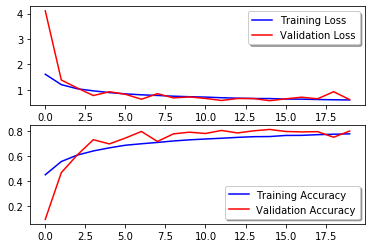

In [58]:
#plot epoch vs (loss and accuracy)

fig, axs = plt.subplots(2,1)
axs[0].plot(history0.history['loss'], color = 'b', label = "Training Loss")
axs[0].plot(history0.history['val_loss'], color = 'r', label = "Validation Loss", axes = axs[0])
legend = axs[0].legend(loc='best', shadow = True)

axs[1].plot(history0.history['accuracy'], color = 'b', label = "Training Accuracy")
axs[1].plot(history0.history['val_accuracy'], color = 'r', label = "Validation Accuracy")
legend = axs[1].legend(loc='best', shadow = True)

#### CNN AUC/ROC and Confusion Matrix on Validation data

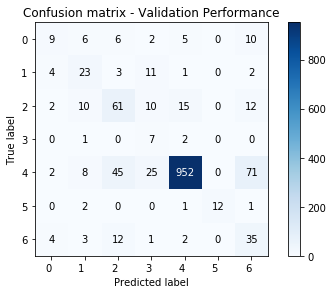


Classification Report

              precision    recall  f1-score   support

       akiec       0.43      0.24      0.31        38
         bcc       0.43      0.52      0.47        44
         bkl       0.48      0.55      0.51       110
          df       0.12      0.70      0.21        10
         mel       0.97      0.86      0.91      1103
          nv       1.00      0.75      0.86        16
        vasc       0.27      0.61      0.37        57

    accuracy                           0.80      1378
   macro avg       0.53      0.61      0.52      1378
weighted avg       0.87      0.80      0.82      1378

The multiclass ROC-AUC score  0.7824799797276212


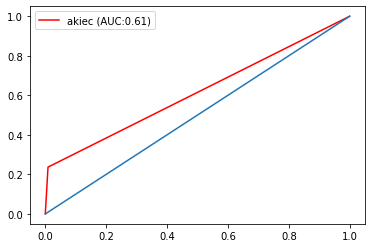

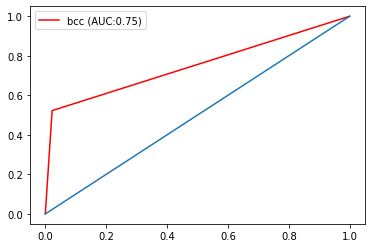

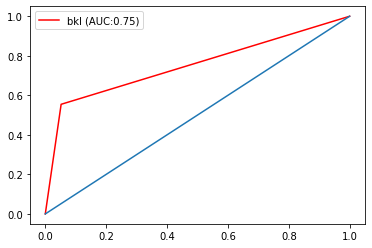

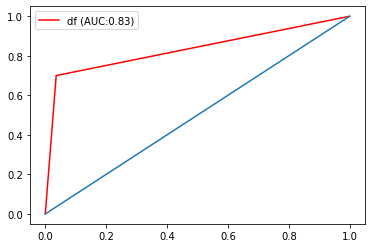

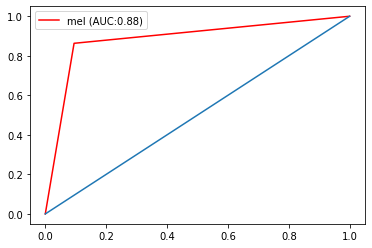

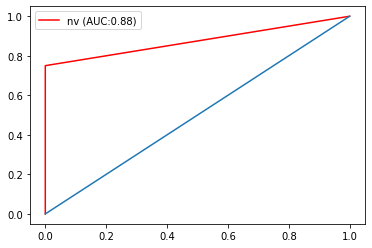

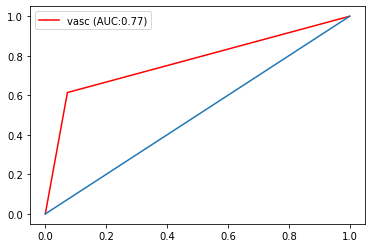

In [91]:
print('The multiclass ROC-AUC score ',computeCM(model0, x_val, y_val, 'Confusion matrix - Validation Performance', df_val))

#### CNN AUC/ROC and Confusion Matrix on test data

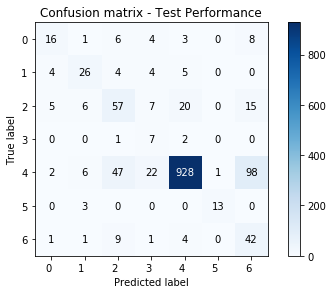


Classification Report

              precision    recall  f1-score   support

       akiec       0.57      0.42      0.48        38
         bcc       0.60      0.60      0.60        43
         bkl       0.46      0.52      0.49       110
          df       0.16      0.70      0.25        10
         mel       0.96      0.84      0.90      1104
          nv       0.93      0.81      0.87        16
        vasc       0.26      0.72      0.38        58

    accuracy                           0.79      1379
   macro avg       0.56      0.66      0.57      1379
weighted avg       0.87      0.79      0.82      1379

The multiclass ROC-AUC score  0.807350562662965


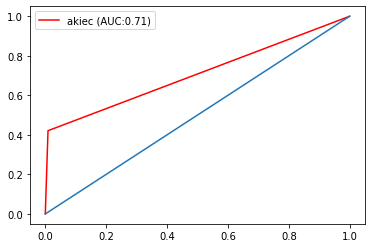

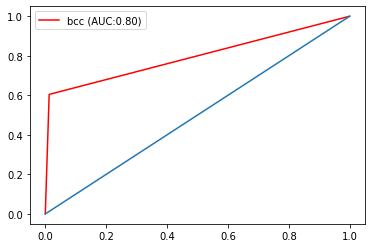

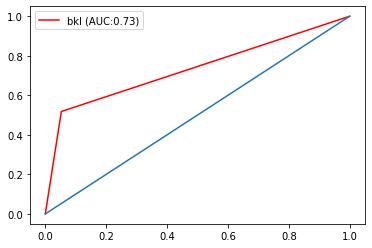

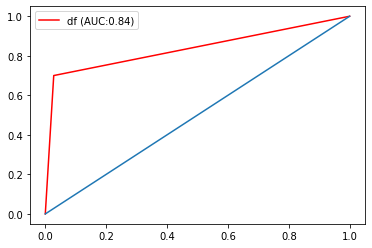

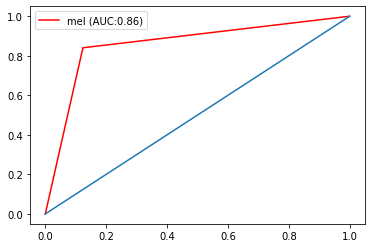

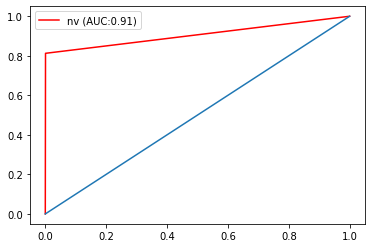

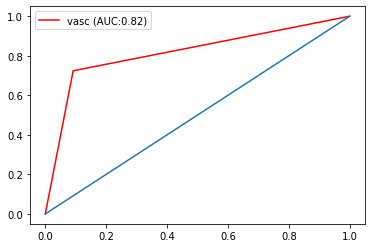

In [85]:
# Confusion Matrix on test
print('The multiclass ROC-AUC score ',computeCM(model0, x_test, y_test, 'Confusion matrix - Test Performance', df_test))

#### CNN Normalized Confusion Matrix

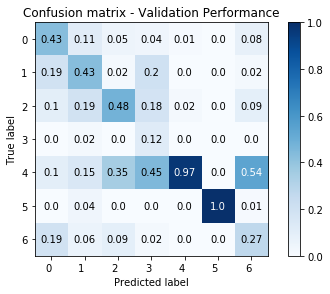

In [99]:
# Normalized Confusion Matrix - test
computeCMNormalized(model0, x_val, y_val, 'Confusion matrix - Validation Performance', df_val)

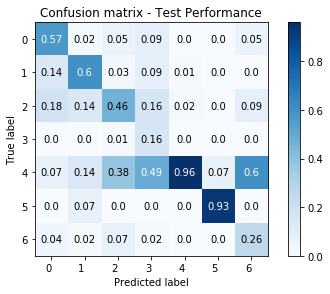

In [81]:
# Normalized Confusion Matrix - test
computeCMNormalized(model0, x_test, y_test, 'Confusion matrix - Test Performance', df_test)

## InceptionV3 + RMSprop

In [40]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

In [41]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(75, 100, 3))  # this assumes K.image_data_format() == 'channels_last'

In [42]:
incV3 = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [47]:
model2 = Sequential()
model2.add(incV3)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(7, activation='softmax', name = 'output_layer'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               262272    
_________________________________________________________________
batch_normalization_119 (Bat (None, 128)               512       
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 7)                 903       
Total params: 22,066,471
Trainable params: 22,031,783
Non-trainable params: 34,688
_____________________________________

In [48]:
#Compile the model
model2.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9) , loss = "categorical_crossentropy", metrics=["accuracy"])

In [49]:
epochs = 40
history2 = model2.fit_generator(train_generator
                                    , steps_per_epoch = x_train.shape[0]//batch_size 
                                    , epochs = epochs
                                    , validation_data = (x_val, y_val)
                                    , verbose = 1
                                    , validation_steps = x_val.shape[0]//batch_size
                                   )

model2.save("inceptionV3_mean_std_norm.h5")

Epoch 1/40


/Users/akshayrajeev/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/akshayrajeev/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


242/242 [==============================] - 575s 2s/step - loss: 0.3864 - accuracy: 0.8704 - val_loss: 0.4455 - val_accuracy: 0.8592
Epoch 2/40
242/242 [==============================] - 564s 2s/step - loss: 0.2509 - accuracy: 0.9126 - val_loss: 0.5306 - val_accuracy: 0.8382
Epoch 3/40
242/242 [==============================] - 565s 2s/step - loss: 0.2056 - accuracy: 0.9282 - val_loss: 0.5216 - val_accuracy: 0.8592
Epoch 4/40
242/242 [==============================] - 655s 3s/step - loss: 0.1805 - accuracy: 0.9360 - val_loss: 0.5192 - val_accuracy: 0.8687
Epoch 5/40
242/242 [==============================] - 607s 3s/step - loss: 0.1575 - accuracy: 0.9460 - val_loss: 0.5544 - val_accuracy: 0.8679
Epoch 6/40
242/242 [==============================] - 605s 2s/step - loss: 0.1384 - accuracy: 0.9521 - val_loss: 0.5842 - val_accuracy: 0.8520
Epoch 7/40
242/242 [==============================] - 598s 2s/step - loss: 0.1241 - accuracy: 0.9566 - val_loss: 0.5597 - val_accuracy: 0.8817
Epoch 8/40

#### Test and Validation results:

In [74]:
calcTestPerformance(model2)

1378/1378 [==============================] - 5s 4ms/step
Validation: accuracy = 0.887518  ;  loss_v = 0.719129
Test: accuracy = 0.882524  ;  loss = 0.693007


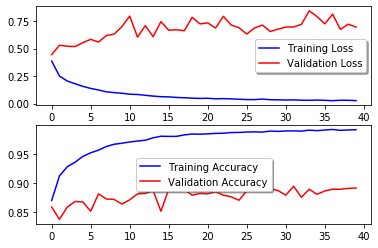

In [65]:
#plot epoch vs (loss and accuracy)

fig, axs = plt.subplots(2,1)
axs[0].plot(history2.history['loss'], color = 'b', label = "Training Loss")
axs[0].plot(history2.history['val_loss'], color = 'r', label = "Validation Loss", axes = axs[0])
legend = axs[0].legend(loc='best', shadow = True)

axs[1].plot(history2.history['accuracy'], color = 'b', label = "Training Accuracy")
axs[1].plot(history2.history['val_accuracy'], color = 'r', label = "Validation Accuracy")
legend = axs[1].legend(loc='best', shadow = True)

#### InceptionV3 + RMSprop AUC/ROC and Confusion Matrix on Validation data

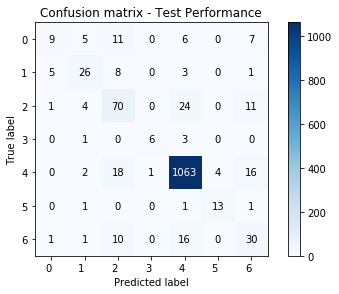


Classification Report

              precision    recall  f1-score   support

       akiec       0.56      0.24      0.33        38
         bcc       0.65      0.60      0.63        43
         bkl       0.60      0.64      0.62       110
          df       0.86      0.60      0.71        10
         mel       0.95      0.96      0.96      1104
          nv       0.76      0.81      0.79        16
        vasc       0.45      0.52      0.48        58

    accuracy                           0.88      1379
   macro avg       0.69      0.62      0.64      1379
weighted avg       0.88      0.88      0.88      1379

The multiclass ROC-AUC score  0.792434287213906


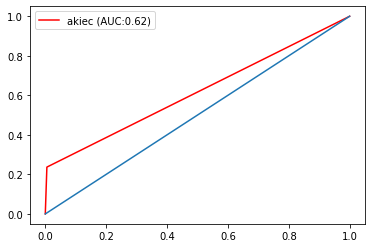

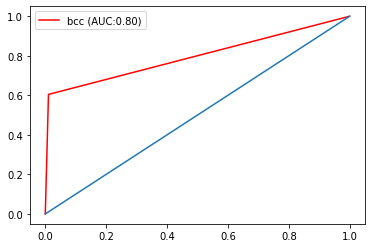

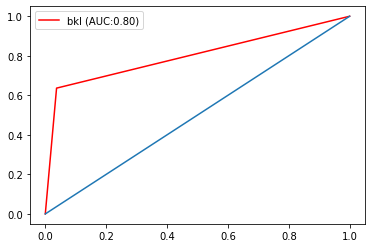

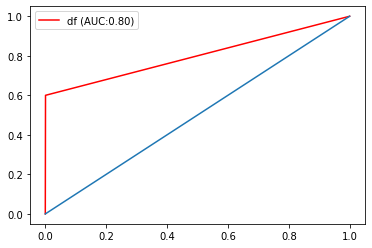

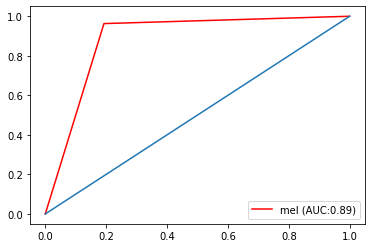

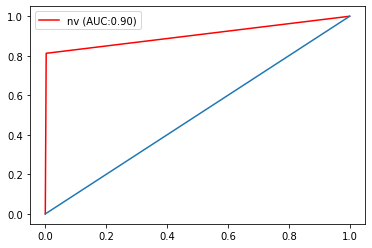

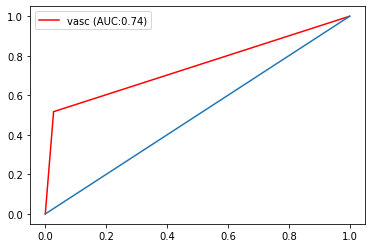

In [80]:
# Confusion Matrix on Validation
print('The multiclass ROC-AUC score ',computeCM(model2, x_test, y_test, 'Confusion matrix - Test Performance', df_test))


#### InceptionV3 + RMSprop AUC/ROC and Confusion Matrix on Test data

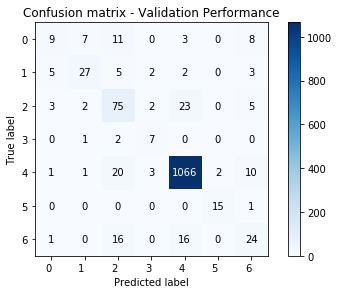


Classification Report

              precision    recall  f1-score   support

       akiec       0.47      0.24      0.32        38
         bcc       0.71      0.61      0.66        44
         bkl       0.58      0.68      0.63       110
          df       0.50      0.70      0.58        10
         mel       0.96      0.97      0.96      1103
          nv       0.88      0.94      0.91        16
        vasc       0.47      0.42      0.44        57

    accuracy                           0.89      1378
   macro avg       0.65      0.65      0.64      1378
weighted avg       0.88      0.89      0.88      1378

The multiclass ROC-AUC score  0.807998902936438


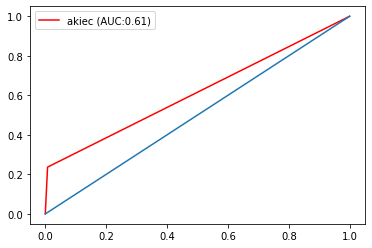

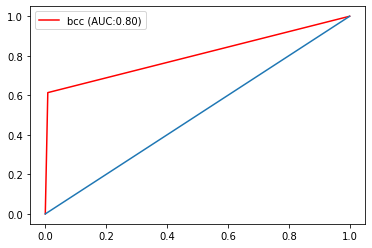

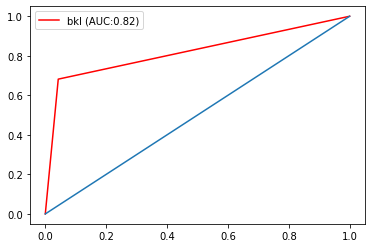

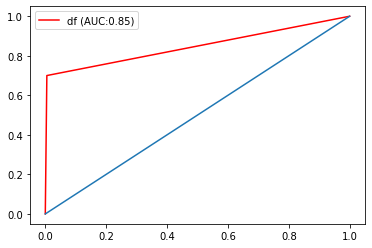

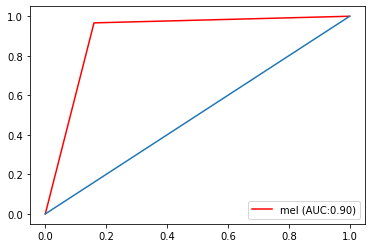

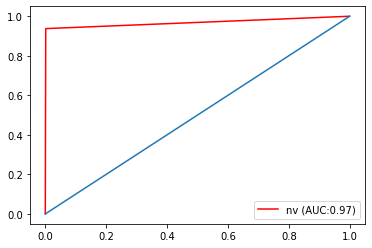

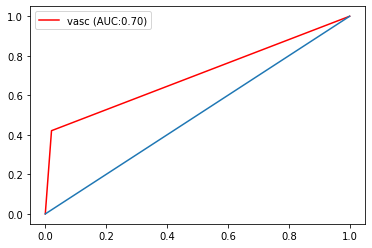

In [103]:
# Confusion Matrix on test
print('The multiclass ROC-AUC score ',computeCM(model2, x_val, y_val, 'Confusion matrix - Validation Performance', df_val))

#### InceptionV3 + RMSprop Normalized Confusion Matrix 

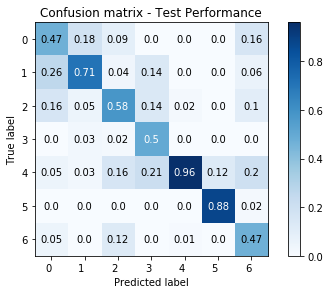

In [101]:
# Normalized Confusion Matrix - test
computeCMNormalized(model2, x_val, y_val, 'Confusion matrix - Test Performance', df_val)

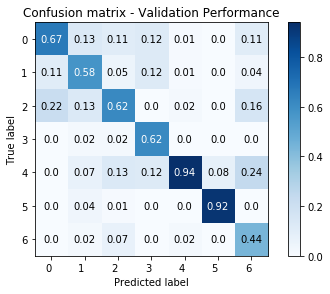

In [67]:
# Normalized Confusion Matrix - test
computeCMNormalized(model2, x_test, y_test, 'Confusion matrix - Test Performance', df_test)

## InceptionV3 + SGD

In [71]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

input_tensor = Input(shape=(75, 100, 3))  # this assumes K.image_data_format() == 'channels_last'

model2c_sgd = Sequential()
model2c_sgd.add(incV3)
model2c_sgd.add(Flatten())
model2c_sgd.add(Dense(128, activation='relu'))
model2c_sgd.add(BatchNormalization())
model2c_sgd.add(Dropout(0.5))
model2c_sgd.add(Dense(7, activation='softmax', name = 'output_layer'))
model2c_sgd.summary()

model2c_sgd.compile(optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True) , loss = "categorical_crossentropy", metrics=["accuracy"])
history2c_sgd = model2c_sgd.fit_generator(train_generator
                                    , steps_per_epoch = x_train.shape[0]//256 
                                    , epochs = epochs
                                    , validation_data = (x_val, y_val)
                                    , verbose = 1
                                    , validation_steps = x_val.shape[0]//256
                                   )

model2c_sgd.save("inceptionV3_mean_std_norm.h5")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               262272    
_________________________________________________________________
batch_normalization_121 (Bat (None, 128)               512       
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 7)                 903       
Total params: 22,066,471
Trainable params: 22,031,783
Non-trainable params: 34,688
_____________________________________

/Users/akshayrajeev/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/akshayrajeev/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


121/121 [==============================] - 295s 2s/step - loss: 0.9199 - accuracy: 0.7572 - val_loss: 0.9516 - val_accuracy: 0.8817
Epoch 2/20
121/121 [==============================] - 294s 2s/step - loss: 0.2244 - accuracy: 0.9744 - val_loss: 0.5366 - val_accuracy: 0.8846
Epoch 3/20
121/121 [==============================] - 296s 2s/step - loss: 0.1411 - accuracy: 0.9859 - val_loss: 0.4316 - val_accuracy: 0.8868
Epoch 4/20
121/121 [==============================] - 293s 2s/step - loss: 0.1037 - accuracy: 0.9895 - val_loss: 0.4269 - val_accuracy: 0.8861
Epoch 5/20
121/121 [==============================] - 278s 2s/step - loss: 0.0853 - accuracy: 0.9909 - val_loss: 0.4360 - val_accuracy: 0.8882
Epoch 6/20
121/121 [==============================] - 280s 2s/step - loss: 0.0726 - accuracy: 0.9926 - val_loss: 0.4492 - val_accuracy: 0.8875
Epoch 7/20
121/121 [==============================] - 272s 2s/step - loss: 0.0586 - accuracy: 0.9946 - val_loss: 0.4473 - val_accuracy: 0.8882
Epoch 8/20

#### Test and Validation results:

In [76]:
calcTestPerformance(model2c_sgd)

1378/1378 [==============================] - 5s 4ms/step
Validation: accuracy = 0.890421  ;  loss_v = 0.497060
Test: accuracy = 0.879623  ;  loss = 0.474492


#### InceptionV3 + SGD AUC/ROC and Confusion Matrix on Validation data

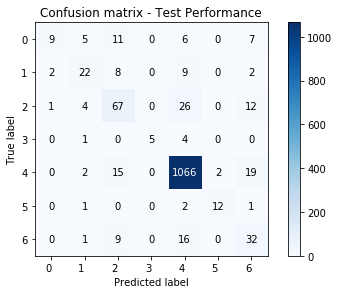


Classification Report

              precision    recall  f1-score   support

       akiec       0.75      0.24      0.36        38
         bcc       0.61      0.51      0.56        43
         bkl       0.61      0.61      0.61       110
          df       1.00      0.50      0.67        10
         mel       0.94      0.97      0.95      1104
          nv       0.86      0.75      0.80        16
        vasc       0.44      0.55      0.49        58

    accuracy                           0.88      1379
   macro avg       0.74      0.59      0.63      1379
weighted avg       0.88      0.88      0.87      1379

The multiclass ROC-AUC score  0.7726191634724185


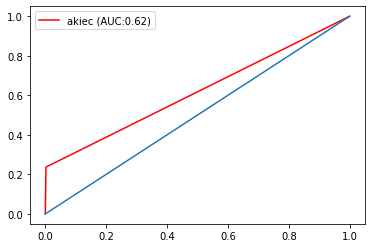

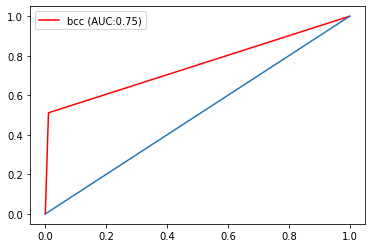

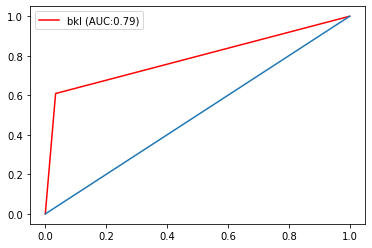

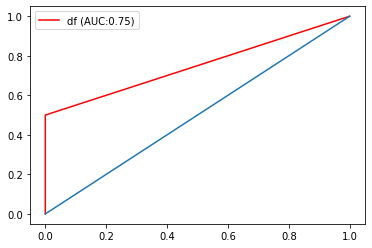

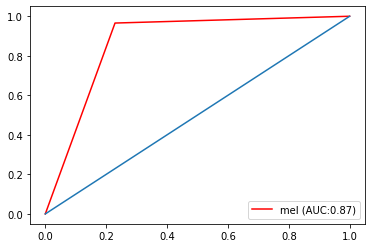

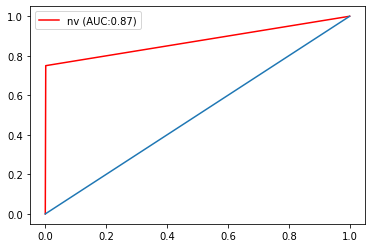

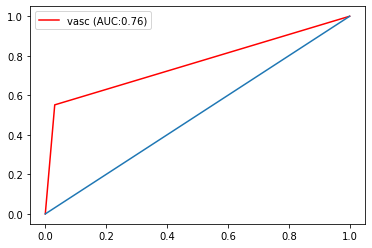

In [82]:
# Confusion Matrix on Validation
print('The multiclass ROC-AUC score ',computeCM(model2c_sgd, x_test, y_test, 'Confusion matrix - Test Performance', df_test))


#### InceptionV3 + SGD AUC/ROC and Confusion Matrix on Test data

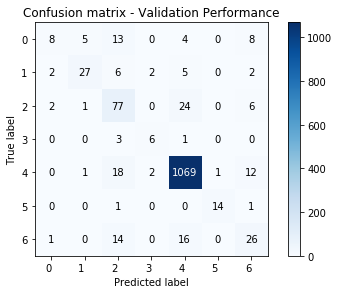


Classification Report

              precision    recall  f1-score   support

       akiec       0.62      0.21      0.31        38
         bcc       0.79      0.61      0.69        44
         bkl       0.58      0.70      0.64       110
          df       0.60      0.60      0.60        10
         mel       0.96      0.97      0.96      1103
          nv       0.93      0.88      0.90        16
        vasc       0.47      0.46      0.46        57

    accuracy                           0.89      1378
   macro avg       0.71      0.63      0.65      1378
weighted avg       0.89      0.89      0.89      1378

The multiclass ROC-AUC score  0.797478175360301


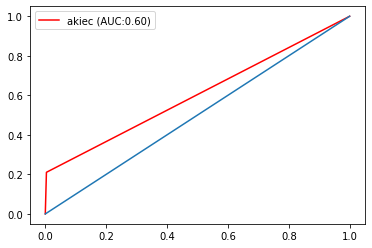

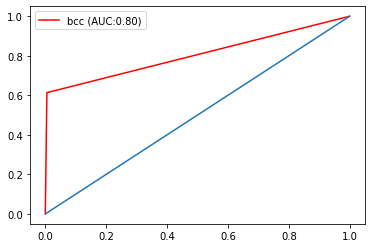

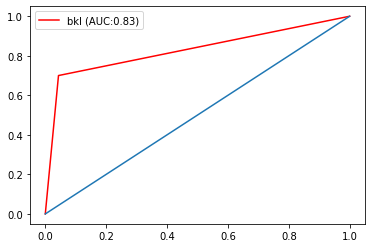

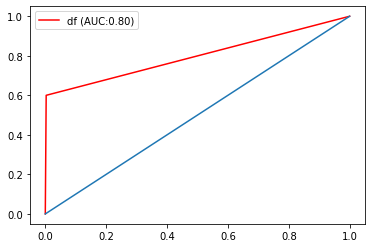

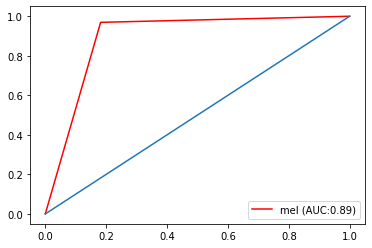

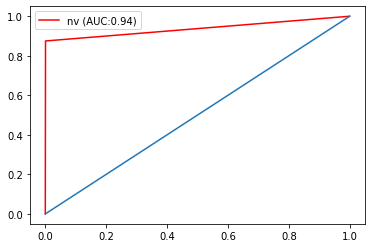

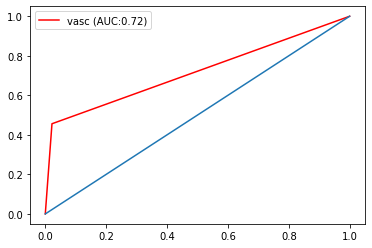

In [105]:
# Confusion Matrix on test
print('The multiclass ROC-AUC score ',computeCM(model2c_sgd, x_val, y_val, 'Confusion matrix - Validation Performance', df_val))


#### InceptionV3 + SGD Normalized Confusion Matrix 

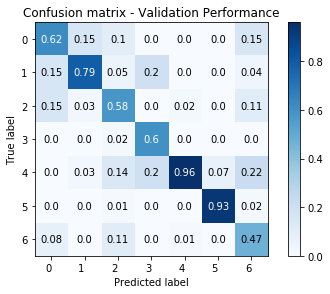

In [110]:
# Normalized Confusion Matrix - test
computeCMNormalized(model2c_sgd, x_val, y_val, 'Confusion matrix - Validation Performance', df_val)

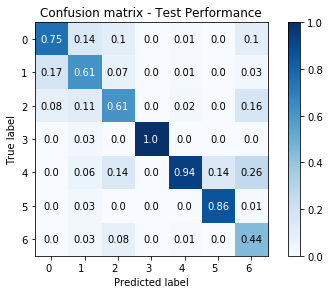

In [83]:
# Normalized Confusion Matrix - test
computeCMNormalized(model2c_sgd, x_test, y_test, 'Confusion matrix - Test Performance', df_test)

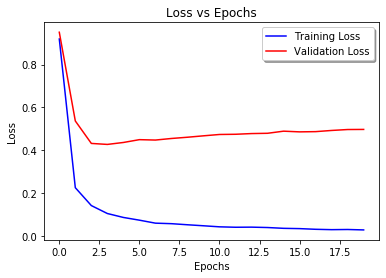

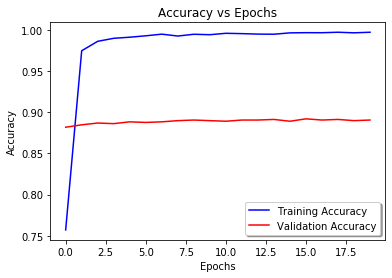

(None, None)

In [112]:
plotTrend(history2c_sgd, "Loss") , plotTrend(history2c_sgd, " ")